# Unit 07: Green Hydrogen Production - Excercise 2


In this application, FINE framework is applied, and a energy system model is optimized in terms of minimal system costs.


All classes which are suitable for your first FINE energy system are introduced. Please run the model cell by cell and try to understand the workflo. 
Finally: Try to answer the Questions that are given in the related Power-Point sheet (Slide 7).

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from os.path import dirname, abspath, join
import os
import pandas as pd



%matplotlib inline
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

Your first model consist only of elecrticity as a commodity. You are simulating a full year or respectively 8760 timesteps, each with a duration of 1 hour (1 year == 8760 hours).

In [2]:
path_to_data = os.path.join((os.getcwd()), "data")
locations = {"Niger"}
commodityUnitDict = {"electricity": r"GW$_{el}$", "hydrogen": r"GW$_{H_{2},LHV}$"}
commodities = {"electricity", "hydrogen"}
numberOfTimeSteps = 8760
hoursPerTimeStep = 1

In [3]:
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0,
)

# 3. Add commodity sources to the energy system model

Commodity sources are added to your model to generate the desired energy. In your case, two sources are modelled. 
The first electricity source generates elecrtcity by operating a onshore wind power plant. The power plant is initailized with corrsponding paramters.
Those parameters are no real data.

### Wind onshore

An Onshore Wind Power Plant is added to the model.  The Operation Rate is limited by the 

In [4]:
onshore_time_series=pd.read_csv(join(path_to_data, "onshore_ts_NER.csv"), index_col=[0]).reset_index(drop=True) #capacity factor [1]
readin=pd.read_csv(join(path_to_data, "onshore_cap_NER.csv"), index_col=[0])#capacity [GW]
onshore_capacity_max=readin.loc['Niger','capacity_kW']/1e6

In [5]:
esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.130, 
        opexPerCapacity=0.025 * 1.130, 
        interestRate=0.08, 
        economicLifetime=20, 
        ),
)

### PV onshore 

The timeseries of maximum operation rate of Niger is added 

In [6]:
pv_time_series=pd.read_csv(join(path_to_data, "solar_ts_NER.csv"), index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(join(path_to_data, "solar_cap_NER.csv"), index_col=[0])['capacity_kW']/1E6 #capacity [GW]

PV onshore plants are added to the model.

In [7]:
esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.450, #1e9EUR/GW, 2030
        opexPerCapacity=0.017 * 0.450, #1e9EUR/a
        interestRate=0.08,  
        economicLifetime=20, 
        ),
)

# 4. Add commodity storages to your energy system model 

To balance the gap between commodity supply and demand, commodity storages can be applied in your model. DEspite the sources and sinks, storages componets require more paramters for initialisation.

In [8]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Li-ion batteries",
        commodity="electricity",
        hasCapacityVariable=True,
        chargeEfficiency=0.95,
        cyclicLifetime=10000,
        dischargeEfficiency=0.95,
        selfDischarge=1 - (1 - 0.03) ** (1 / (30 * 24)),
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.151,
        opexPerCapacity=0.002,
        interestRate=0.08,
        economicLifetime=22,
    )
)

# 5. Add commodity conversion components to the energy system model 

In general, conversion components convert a unit of a commodity in another commodity. Therefore, a conversion ratio must be given. 
In our case, we want to implement an electrolyser to convert electricity to hydrogen. 

In [9]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Electroylzers",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.02},
        hasCapacityVariable=True,
        investPerCapacity=0.5,
        opexPerCapacity=0.5 * 0.025,
        interestRate=0.08,
        economicLifetime=10,
    )
)

# 6. Add commodity sinks to the energy system model

An electricity demand is added to your model. The demand causes  the installation of source-components. The major objective of your model is to balance demand and supply of your commidities in each timestep. 

### Electricity demand

In [10]:
electricity_demand_operationRateFix=pd.read_csv(join(path_to_data, "elec_demand_NER.csv"), index_col=[0]) 

In [11]:

print(join(path_to_data),"elec_demand_NER.csv")
esM.add(
    fn.Sink(
        esM=esM, 
        name="Electricity Demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, 
    ),
)
    

c:\Users\m.stargardt\work\africaModel\wascal_graduate_school\student_files\exercises\Unit_07_GreenHydrogenProduction\data elec_demand_NER.csv


### 5.1 Hydrogen demand 
To implement a conversion technology, we have to add a hydrogen demand. Thus, a hydrogen demand is added in the next step. 

In [12]:
print (join(path_to_data,"hy_demand_NER.csv"))

c:\Users\m.stargardt\work\africaModel\wascal_graduate_school\student_files\exercises\Unit_07_GreenHydrogenProduction\data\hy_demand_NER.csv


In [13]:
hydrogen_demand_operationRateFix=pd.read_csv(join(path_to_data, "hy_demand_NER.csv"), index_col=[0]) 

In [14]:


esM.add(
    fn.Sink(
        esM=esM,
        name="Hydrogen demand",
        commodity="hydrogen",
        hasCapacityVariable=False,
        operationRateFix=hydrogen_demand_operationRateFix,
    )
)

C:\Users\m.stargardt\work\africaModel\wascal_graduate_school\student_files\exercises\Unit_07_GreenHydrogenProduction\data

# 6. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

Clustering of your timeseries will save  computational time. In this case, you only simulate 30 days (24 hours each). 

It is not mandatory to apply this function. However, especially if you are using your own computer, time series aggregation will help you to get results in time and, also, will protect your computer against material damage. 


In [15]:
esM.aggregateTemporally(numberOfTypicalPeriods=30)


Clustering time series data with 30 typical periods and 24 time steps per period...
		(0.7191 sec)



 c:\Users\m.stargardt\Anaconda3\envs\GradSchoolESM\lib\site-packages\tsam\timeseriesaggregation.py:1076: UserWarning:Something went wrong: At least one minimal value of the aggregated time series exceeds the minimal value the input time series


This command will start your optimization. After the calculation is started, you can't change any input parameters anymore. 

In [16]:
esM.optimize(timeSeriesAggregation=True, solver="glpk")

Time series aggregation specifications:
Number of typical periods:30, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7501 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3400 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0590 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.1530 sec)

		(0.0010 sec)

Declaring objective function...
		(0.1580 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\MA275~1.STA\AppData\Local\Temp\tmp4nej05om.glpk.raw --wglp
 C:\Users\MA275~1.STA\AppData\Local\Temp\tmpekeldjol.glpk.gl

# 7. Selected results output
You succesfully calculated your first energy system model by application of the FINE framework. 
Please make sure that you have understodd all steps above. 
If not, please ask the supervisor in time. 

Once, you have done your optimization. Fine offers various options to illustrate your results. 
Following, some options are applied. 


### Results for Sources and Sinks

A summarising table for installation and operation of sources and sinks, and their relatetd costs is displayed. 

In [17]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

Niger
Component          Property  Unit                               
Electricity Demand operation [GW$_{el}$*h/a]          154.934375
                             [GW$_{el}$*h]            154.934375
Hydrogen demand    operation [GW$_{H_{2},LHV}$*h/a]   712.194816
                             [GW$_{H_{2},LHV}$*h]     712.194816
PV                 TAC       [1e9 Euro/a]               0.097349
                   capacity  [GW$_{el}$]                1.820162
                   capexCap  [1e9 Euro/a]               0.083424
                   invest    [1e9 Euro]                 0.819073
                   operation [GW$_{el}$*h/a]         1243.759086
                             [GW$_{el}$*h]           1243.759086
                   opexCap   [1e9 Euro/a]               0.013924

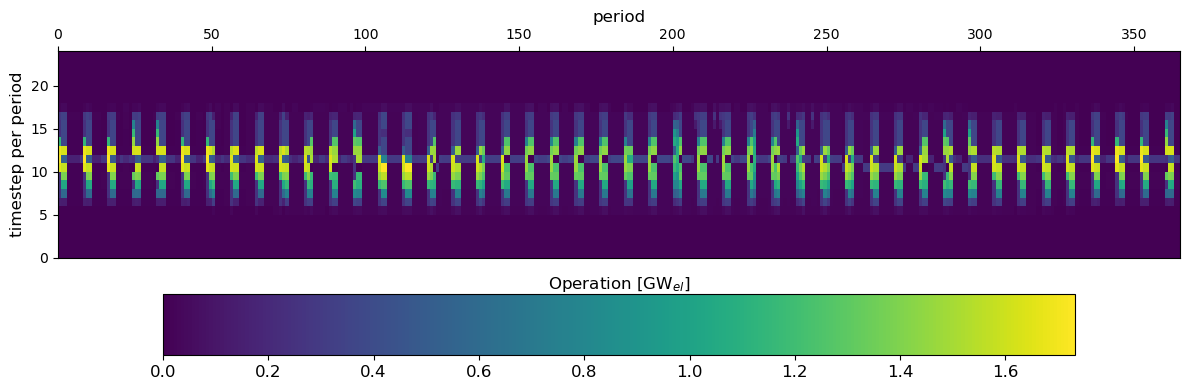

In [18]:
fig,ax= fn.plotOperationColorMap(esM,"PV","Niger")

To display the electricity demand ,time series (either one or two dimensional)are plotted.

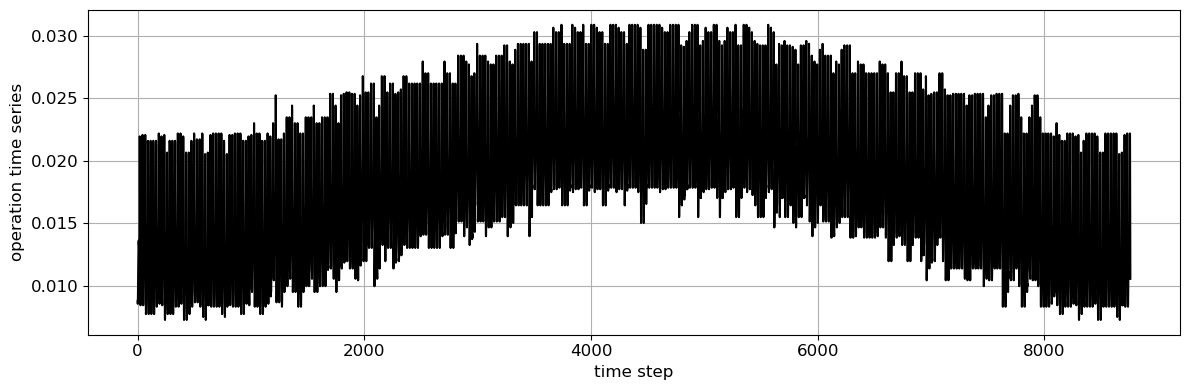

In [19]:
fig, ax = fn.plotOperation(esM, "Electricity Demand", "Niger")

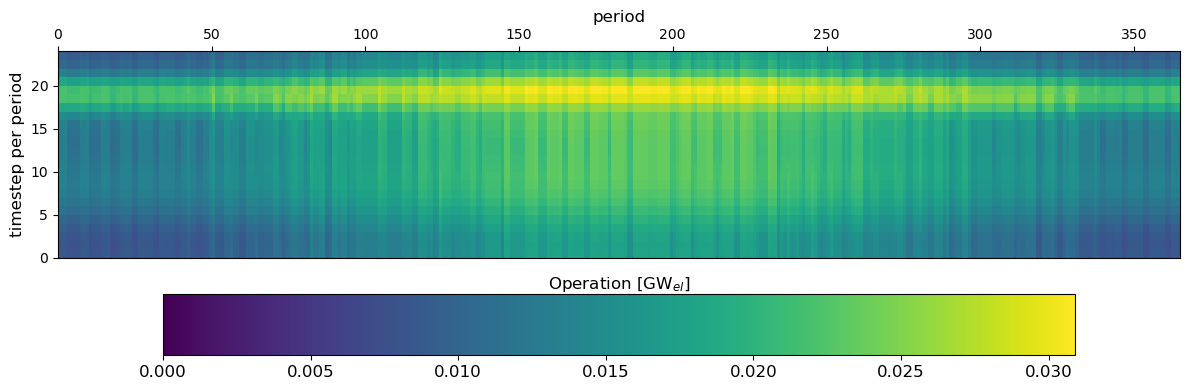

In [20]:
fig, ax = fn.plotOperationColorMap(esM, "Electricity Demand", "Niger")

To display the hydrogen demand ,time series (either one or two dimensional)are plotted.

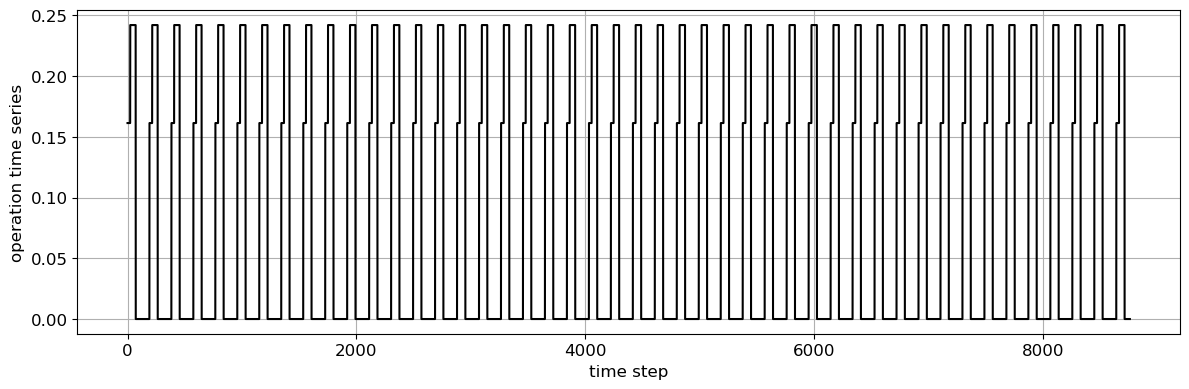

In [21]:
fig, ax = fn.plotOperation(esM, "Hydrogen demand", "Niger")

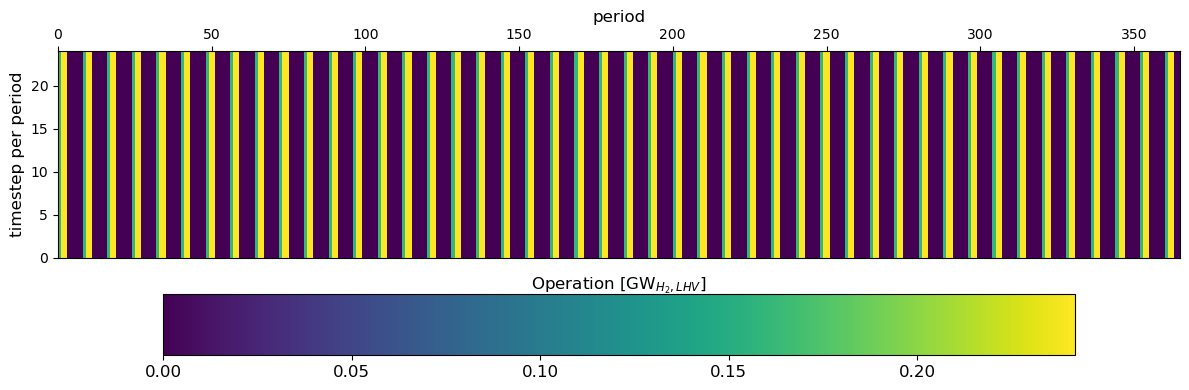

In [22]:
fig, ax = fn.plotOperationColorMap(esM, "Hydrogen demand", "Niger")

### Results for Commodity Storages

To analyze the impact of the sorages, the results have  to be displayed. The following comments display both a summarising table and a color map indicating the operatin of the storage.

In [23]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

Niger
Component        Property           Unit                       
Li-ion batteries TAC                [1e9 Euro/a]       0.087469
                 capacity           [GW$_{el}$*h]      5.205627
                 capexCap           [1e9 Euro/a]       0.077058
                 invest             [1e9 Euro]          0.78605
                 operationCharge    [GW$_{el}$*h/a]  724.912009
                                    [GW$_{el}$*h]    724.912009
                 operationDischarge [GW$_{el}$*h/a]  653.508464
                                    [GW$_{el}$*h]    653.508464
                 opexCap            [1e9 Euro/a]       0.010411

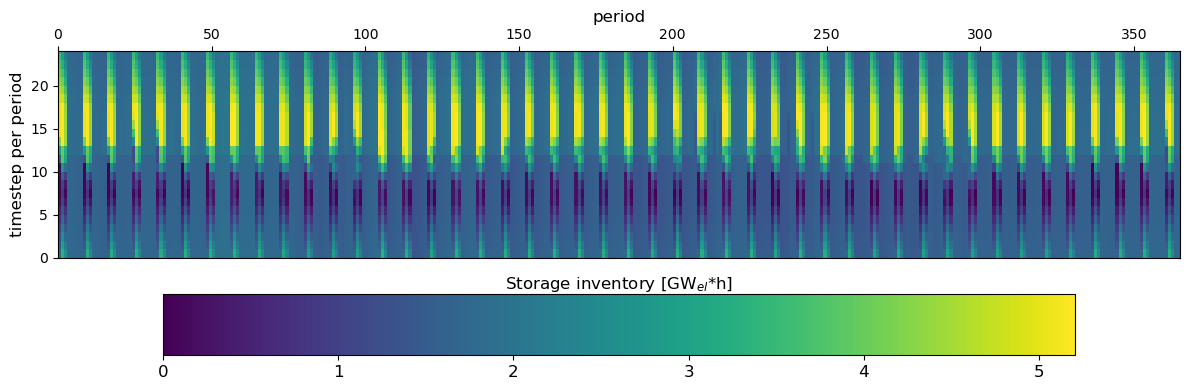

In [24]:
fig, ax = fn.plotOperationColorMap(
    esM,
    "Li-ion batteries",
    "Niger",
    variableName="stateOfChargeOperationVariablesOptimum",
)

### Results for Conversion Model

Firstly, the summarizing table is displayed.
Secondly, the operationColorMap is shown to analyze the operation of installed conversion components.

In [25]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

Niger
Component     Property  Unit                        
Electroylzers TAC       [1e9 Euro/a]        0.030072
              capacity  [GW$_{el}$]         0.345591
              capexCap  [1e9 Euro/a]        0.025752
              invest    [1e9 Euro]          0.172796
              operation [GW$_{el}$*h/a]  1017.421166
                        [GW$_{el}$*h]    1017.421166
              opexCap   [1e9 Euro/a]         0.00432

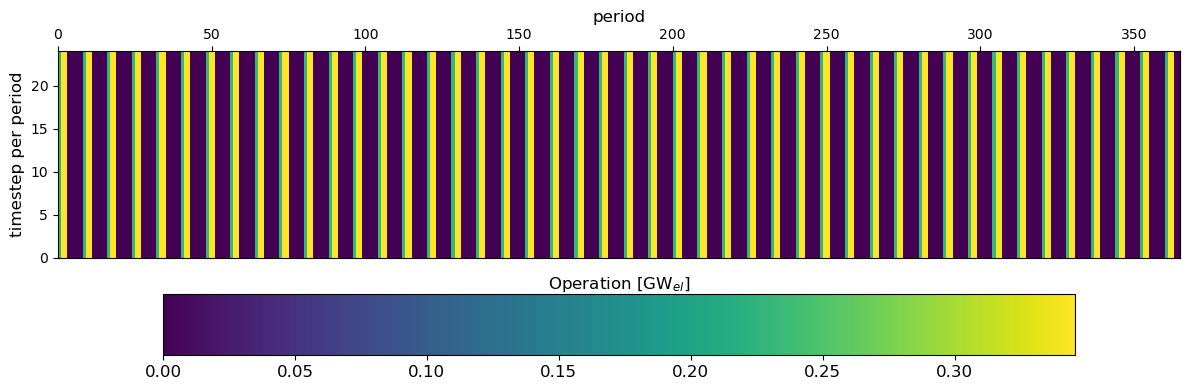

In [26]:
fig, ax = fn.plotOperationColorMap(esM, "Electroylzers", "Niger")

## Well done! The Excercise is done!